# GPs. Notebook 3. Sparse GPs

------------------------------------------------------
*Machine Learning, Master in Information & Health Engineering

*Pablo M. Olmos olmos@tsc.uc3m.es*


------------------------------------------------------

Today, we will learn about [Sparse GPs](http://mlg.eng.cam.ac.uk/zoubin/papers/aistats07localGP.pdf), that aim at selecting a subset of points to represent the GP and thus lower down its complexity, since future prediction won't rely on the entire dataset.

Recommended about Sparse GPs:
- [James Hensman Leture at the 2013 Gaussian Process Summer School](https://www.youtube.com/watch?v=66vH34Ykfo0) (Video) and [slides](http://gpss.cc/gpss13/assets/Sheffield-GPSS2013-Hensman.pdf).
- [James Hensman Blog about Sparse GPs](https://www.prowler.io/blog/sparse-gps-approximate-the-posterior-not-the-model)


In [1]:
# You can also install GPy using the following command (Works on Windows too!)

#!pip install GPy 

In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]

# Sparse Regression with Gaussian Processes

In GPs, evaluating $p(\mathbf{Y}|\mathbf{X})$ directly is an expensive operation that involves the **inversion of a $N\times N$ matrix** ($N$ is the number of data points), thus requiring
$\mathcal{O}(n^3)$ time complexity.  In order to reduce the computational complexity, it is proposed to use a collection of $m$ **inducing points** – a set of points lying in the
same input space with corresponding values in the output space. 


These inducing points aim to **summarise the characteristics of the function using less points** than the training data.  Intuitively, the collection of all training points may contain lots of redundancy, as many points may be given in uninteresting regions.

Despite we won't go through the technical details, with the following examples our goal is to show the effectiveness of the method and how to use it in practice.

## Toy example using a generative model

Now we'll sample a Gaussian process regression problem directly from a Gaussian process prior. We'll use an exponentiated quadratic covariance function with a lengthscale and variance of 1 and sample 50 equally spaced points.

In [2]:
N = 50
noise_var = 0.05
np.random.seed(101)
X = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

### Full Gaussian Process Fit

Now we use GPy to optimize the parameters of a Gaussian process given the sampled data. Here, there are no approximations, we simply fit the full Gaussian process.


Name : GP regression
Objective : 50.08607234668699
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  1.6582486035657051  |      +ve      |        
  rbf.lengthscale          |  1.1121538300756562  |      +ve      |        
  Gaussian_noise.variance  |  0.2361342370011008  |      +ve      |        


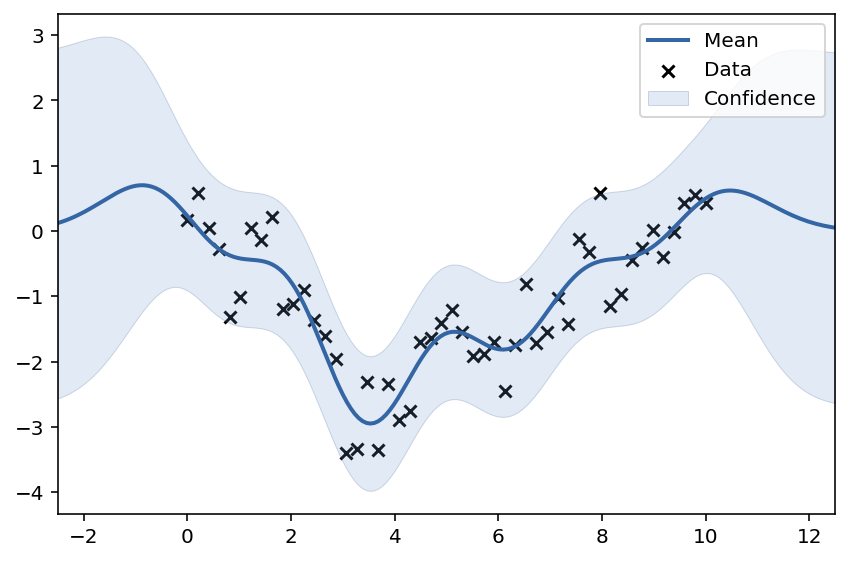

In [3]:
m_full = GPy.models.GPRegression(X,y) # Default options
m_full.optimize('bfgs')
m_full.plot()
print(m_full)

### A Poor Selection of Inducing points

Now we construct a sparse Gaussian process. This model uses the inducing variable approximation and initialises the inducing variables in two 'clumps'. Our initial fit uses the correct covariance function parameters, but a badly placed set of inducing points.



Name : sparse_gp
Objective : 260.8098280164652
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (6, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.05  |      +ve      |        


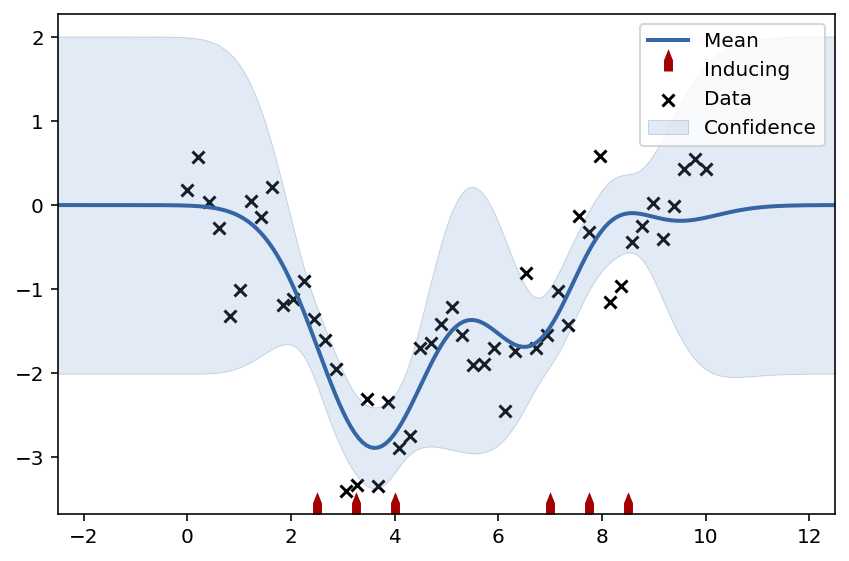

In [4]:
Z = np.hstack((np.linspace(2.5,4.,3),np.linspace(7,8.5,3)))[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.plot()
print(m)

**Notice how the fit is reasonable where there are inducing points, but bad elsewhere.**

### Optimizing Covariance Parameters

Next, we will try to fit the covariance function parameters, given that the inducing inputs are held in their current location.


Name : sparse_gp
Objective : 53.973553703324114
Number of Parameters : 9
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |                value  |  constraints  |  priors
  inducing_inputs          |               (6, 1)  |     fixed     |        
  rbf.variance             |   1.7390511816220304  |      +ve      |        
  rbf.lengthscale          |    3.023126509411214  |      +ve      |        
  Gaussian_noise.variance  |  0.37299000979874297  |      +ve      |        


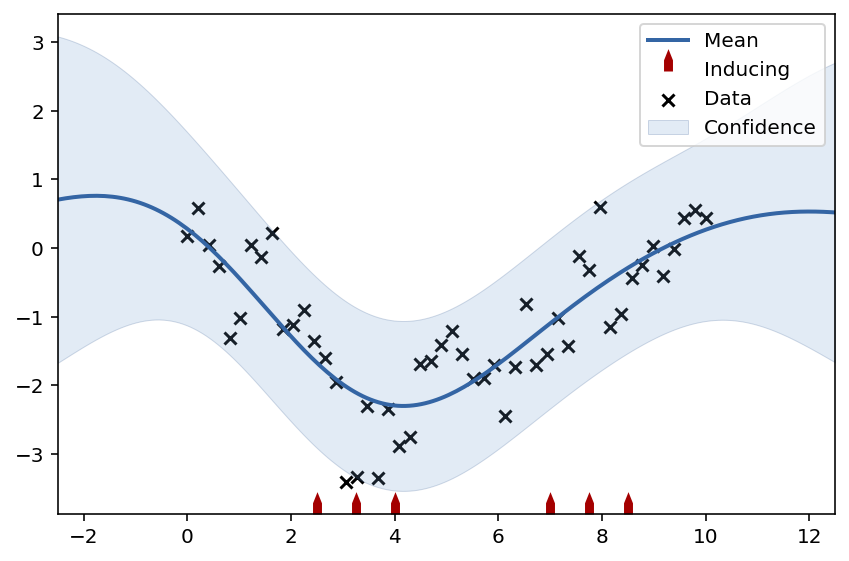

In [5]:
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot()
print(m)

The poor location of the inducing inputs causes the model to 'underfit' the data. The lengthscale is much longer than the full GP, and the noise variance is larger. **This is due to the poor location of the inducing inputs.**

### Optimizing Inducing Inputs

Firstly we try optimzing the location of the inducing inputs to fix the problem, however we still get a larger lengthscale than the Gaussian process we sampled from (or the full GP fit we did at the beginning).


Name : sparse_gp
Objective : 53.4446557149148
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |              (6, 1)  |               |        
  rbf.variance             |  1.4233475604971653  |      +ve      |        
  rbf.lengthscale          |  2.1946038623632833  |      +ve      |        
  Gaussian_noise.variance  |  0.3521300348158982  |      +ve      |        


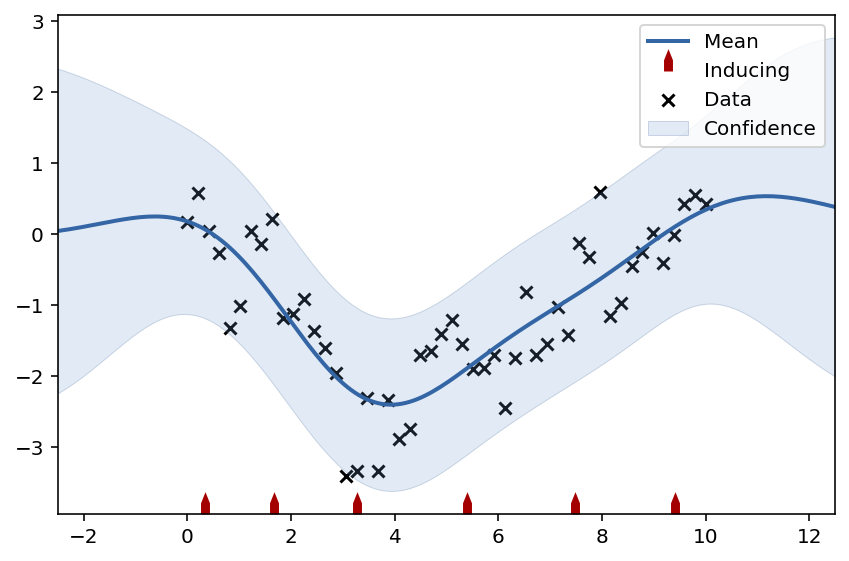

In [6]:
m.randomize()
m.Z.unconstrain()
m.optimize('bfgs')
m.plot()
print(m)

The inducing points spread out to cover the data space, but the fit isn't quite there. We can try increasing the number of the inducing points.

### Train with More Inducing Points

Now we try 12 inducing points, rather than the original six. We then compare with the full Gaussian process likelihood.

[[-50.09844733]] -50.08607234668699


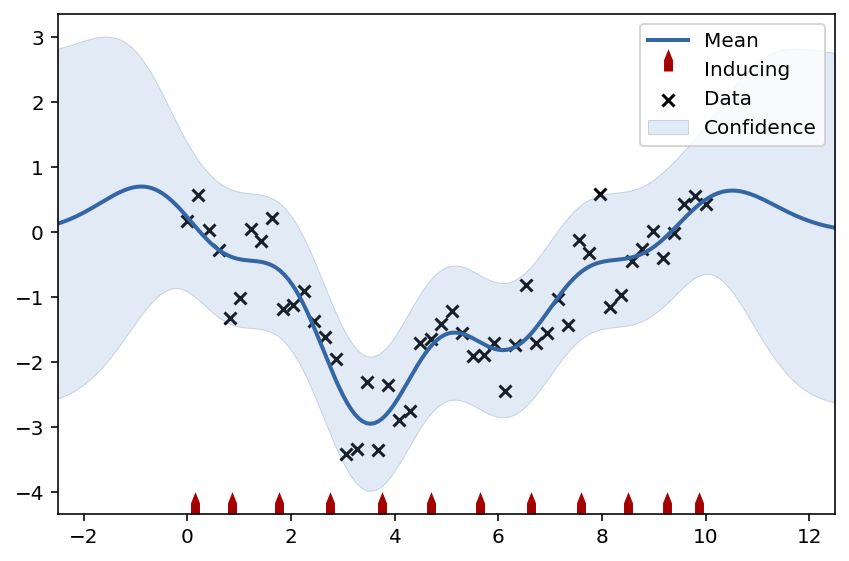

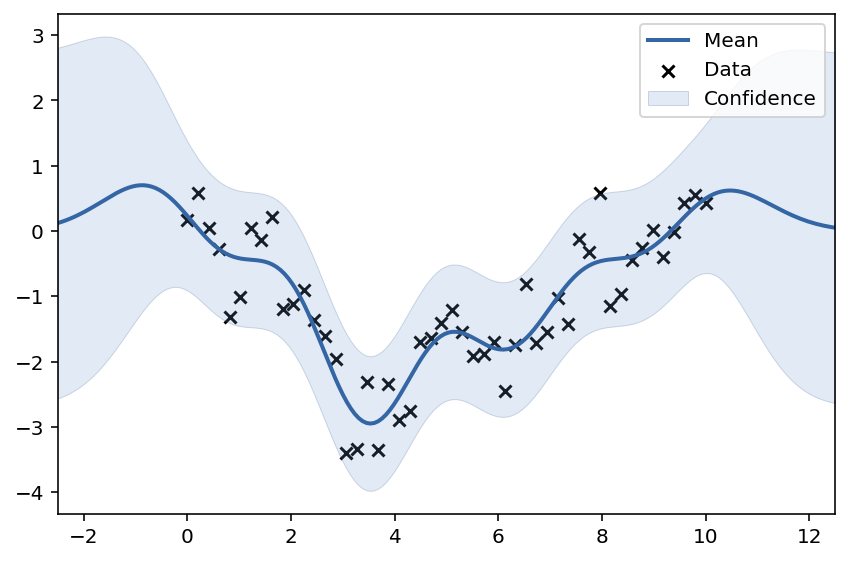

In [16]:
Z = np.random.rand(12,1)
m = GPy.models.SparseGPRegression(X,y,Z=Z)

m.optimize('bfgs')
m.plot()
m_full.plot()
print(m.log_likelihood(), m_full.log_likelihood())

This time, we have enough inducing points and the fit resembles that of the GP. 

# More about Scalable GPs: towards big data

There's been quite an intense research on how to make GPs scalable by combining their use with the latest advances in [Variational Inference](https://arxiv.org/abs/1601.00670), [stochastic optimization](http://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent) and [approximate matrix inversion](https://arxiv.org/abs/1809.11165).

Three representative papers:

- http://proceedings.mlr.press/v5/titsias09a.html
- https://arxiv.org/abs/1610.05392
- https://arxiv.org/abs/1809.11165

Three libraries you should keep in mind:

- GPyTorch: https://gpytorch.ai/
- GPFlow: https://github.com/GPflow/GPflow
- Pyro: https://pyro.ai/

